# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load the data

In [2]:
df = pd.read_csv("../data/processed/youtube_combined_data.csv")
print(f"Data loaded with shape: {df.shape}")

%run "./02_data_cleaning.ipynb"
%run "./03_feature_engineering.ipynb"

df = clean_data(df)
df = feature_engineering(df)
df = drop_unused_columns(df)

print(f"Data after preprocessing has shape: {df.shape}")

Data loaded with shape: (50160, 16)
Data after preprocessing has shape: (49229, 17)


In [3]:
# Define target and feature lists

TARGET = "engagement_rate_log"

CATEGORICAL_FEATURES = ['category_id', 'captions_flag']

NUMERIC_FEATURES = [
    'total_videos','channel_age_days','duration_minutes',
    'subscriber_count_log','title_length','title_words',
    'title_exclamation','title_question',
    'publish_hour_sin','publish_hour_cos',
    'publish_dow_sin','publish_dow_cos','is_hd'
]

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES


# GROUP SPLIT

In [4]:
X = df[ALL_FEATURES].copy()
y = df[TARGET].copy()
groups = df['channel_id']

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train = X.iloc[train_idx].copy()
X_test  = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx].copy()
y_test  = y.iloc[test_idx].copy()


In [5]:
train_means = y_train.groupby(X_train['category_id']).mean()

X_train['category_te'] = X_train['category_id'].map(train_means)
X_test['category_te']  = X_test['category_id'].map(train_means)

NUMERIC_FEATURES.append('category_te')


In [6]:
for col in CATEGORICAL_FEATURES:
    mapping = {v: i for i, v in enumerate(X_train[col].unique())}
    X_train[col] = X_train[col].map(mapping).fillna(-1).astype(int)
    X_test[col]  = X_test[col].map(mapping).fillna(-1).astype(int)


In [7]:
# Clipping of numeric features

def robust_clip(train_col, test_col):
    q1, q3 = train_col.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return train_col.clip(lo, hi), test_col.clip(lo, hi)

for col in ['total_videos', 'channel_age_days']:
    X_train[col], X_test[col] = robust_clip(X_train[col], X_test[col])


# Model Fit

In [8]:
base_model = GradientBoostingRegressor(random_state=42)

param_grid = {
    "learning_rate": [0.03, 0.05],
    "n_estimators": [200, 300],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 4],
    "subsample": [0.8, 1.0]
}

search = HalvingGridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    factor=2,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1
)

search.fit(X_train, y_train)

final_model = GradientBoostingRegressor(
    **search.best_params_,
    random_state=42
)

final_model.fit(X_train, y_train)


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 616
max_resources_: 39475
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 616
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 48
n_resources: 1232
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 2
n_candidates: 24
n_resources: 2464
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 3
n_candidates: 12
n_resources: 4928
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 4
n_candidates: 6
n_resources: 9856
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 5
n_candidates: 3
n_resources: 19712
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 6
n_candidates: 2
n_resources: 39424
Fitting 3 folds for each of 2 candidates, totalling 6 fits


,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.03
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",300
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.8
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",4
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",4
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in thelef

# Evaluation

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = final_model.predict(X_test)
y_train_pred = final_model.predict(X_train)

print("TEST MAE:", mean_absolute_error(y_test, y_pred))
print("TEST RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("TEST R2:", r2_score(y_test, y_pred))
print()
print("TRAIN MAE:", mean_absolute_error(y_train, y_train_pred))
print("TRAIN RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("TRAIN R2:", r2_score(y_train, y_train_pred))


TEST MAE: 0.15368399501638003
TEST RMSE: 0.2106261546572283
TEST R2: 0.2664102922927686

TRAIN MAE: 0.1392486555919487
TRAIN RMSE: 0.19095826739746943
TRAIN R2: 0.383150256787936


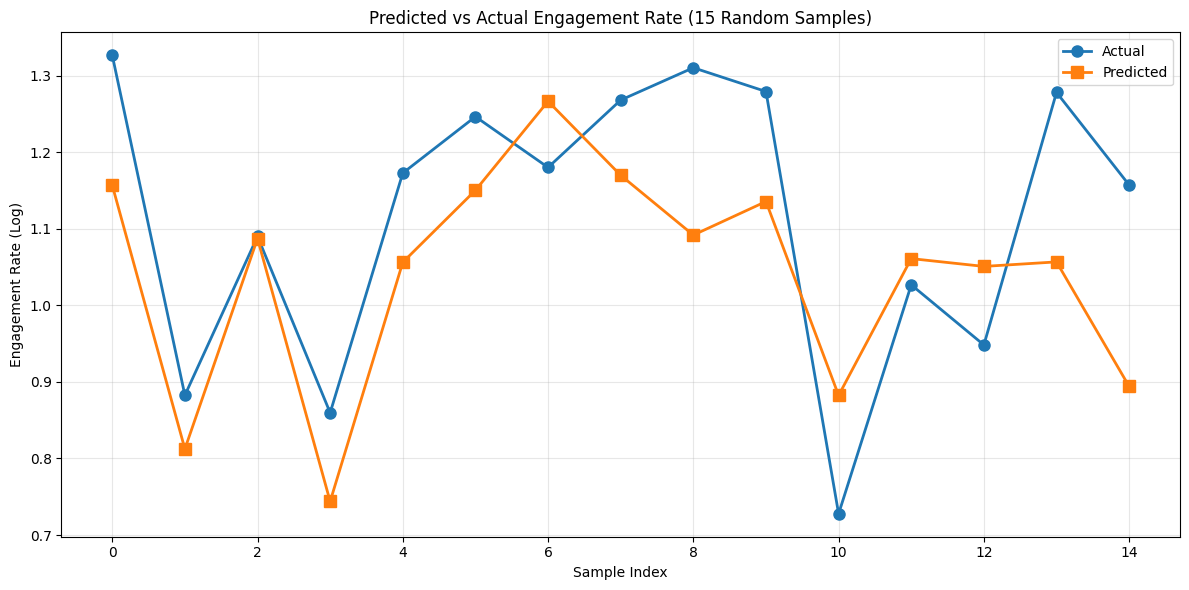

In [12]:
import matplotlib.pyplot as plt

# Select random 15 indices from test set
random_indices = np.random.choice(len(y_test), 15, replace=False)
random_indices = sorted(random_indices)

# Get actual and predicted values
actual_values = y_test.iloc[random_indices].values
predicted_values = y_pred[random_indices]

# Create line chart
plt.figure(figsize=(12, 6))
plt.plot(range(15), actual_values, marker='o', label='Actual', linewidth=2, markersize=8)
plt.plot(range(15), predicted_values, marker='s', label='Predicted', linewidth=2, markersize=8)
plt.xlabel('Sample Index')
plt.ylabel('Engagement Rate (Log)')
plt.title('Predicted vs Actual Engagement Rate (15 Random Samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save Model

In [11]:
import joblib
import json
import os

os.makedirs("../models", exist_ok=True)

# Save model
joblib.dump(final_model, "../models/gradient_boosting_model.pkl")

# Save target encoding mapping
joblib.dump(train_means, "../models/category_te_mapping.pkl")

# Ensure category_te is included
if "category_te" not in ALL_FEATURES:
    ALL_FEATURES.append("category_te")

# Save metadata
model_info = {
    "model_type": "GradientBoostingRegressor",
    "numeric_features": NUMERIC_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
    "all_features": ALL_FEATURES,
    "target": TARGET,
    "category_te_global_mean": float(train_means.mean()),
    "best_params": search.best_params_,
    "test_metrics": {
        "MAE": float(mean_absolute_error(y_test, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_test, y_pred))),
        "R2": float(r2_score(y_test, y_pred))
    },
    "train_metrics": {
        "MAE": float(mean_absolute_error(y_train, y_train_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_train, y_train_pred))),
        "R2": float(r2_score(y_train, y_train_pred))
    }
}

with open("../models/gradient_boosting_model_info.json", "w") as f:
    json.dump(model_info, f, indent=4)

print("Model + metadata saved successfully for UI")

Model + metadata saved successfully for UI
